# Interatomic force field (IFF) optimization for W-based metal alloys

Author: Lukas Vlcek

Start Date: 2018-04-22

In [7]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-07-14 19:45:25.250775


In [8]:
# Notebook setup
%matplotlib inline
import os
import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import h5py

## 1. Introduction

**Goal:** Optimize EAM potential for W using the functional form of Bonny et al. (2017), and target data from Marinica et al. (2013) and German. Show that using this simplified EAM form we can develop a more predictive model of W compared to EAM2 model of Marinica.

## 2. Model

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V_{t_it_j}\left(r_{ij}\right) + F_{t_i}\left(\rho_i\right) \right] $$

Here $V_{t_it_j}$ is pair interaction between atom types $t_i$ and $t_j$ at distance $r_{ij}$ defined as

$$ V_{t_it_j}\left(r_{ij}\right) = \sum_{k=1}^{N_p}\left[a_k\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ $$

where $\Theta$ is Heaviside step function.
$F_{t_i}$ is the manybody embedding function

$$ F_{t_i}(\rho_i) = A_{t_i}\sqrt{\rho_i} + B_{t_i}\rho + C_{t_i}\rho^2 $$

where $\rho_i$ effective electron density 

$$ \rho_i = \sum_{j\ne i}^N \phi_{t_j}\left(r_{ij}\right) $$

and $\phi$ is cohesive potential

$$ \phi\left(r_{ij}\right) = D_{t_j}\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right) $$

In [14]:
# Define EAM functions

# Pair potential (cubic splines). Parameters: distance (r), spline parameters (aa), spline nodes (cc)
V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

## 3. Target data

### Bulk properties of tungsten
from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)

T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

### Defect properties
(from _Marinica et.al_)

Based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

### List of available atomic configurations and DFT data

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy
    * vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
  * Screw dislocation
    * 111_easy_core (135 atoms)?

## 5. Optimization

Optimization is based on minimization of statistical distance.

Starting potential (initial guess) is derived by fitting the chosen functional form to EAM2 potential of Marinica (2013) et al. with Bonny et al. (2017) corrections.

Parameters of EAM2 potential by Marinica (2013)

In [18]:
# Cohesive potential parameters
rho_w_a = [-0.420429e1, 0.518217702, 0.5627208e-1, 0.344164179e-1]
rho_w_r = [2.5, 3.1, 3.5, 4.9]

# Embedding function parameters
F_w_a = [-5.946454, 0.0, -0.049477] # Original Marinica
Fc_w_a = [-5.524855802, 2.317313103e-1, -3.665345949e-2, 8.989367404e-3] # Bonny's correction

# Pair potential parameters
arr = np.array([
(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)])

V_w_a = arr[:,1]
V_w_r = arr[:,2]

Potential functions converting Marinica to Bonny

In [17]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# Rescaled pair potential function
V_eam2 = lambda r: 0.5*(V(r, V_w_a, V_w_r) - 2*C*rho(r, rho_w_a, rho_w_r))

# Rescaled cohesive potential function
rho = lambda r: phi(r, rho_w_a, rho_w_r)*S

# Rescaled embedding function with Bonny's correction
Fe = lambda d, a: F(d/S, a) + C/S*d # rescaled potential
Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3 # correction
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2) # rescaled + correction

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


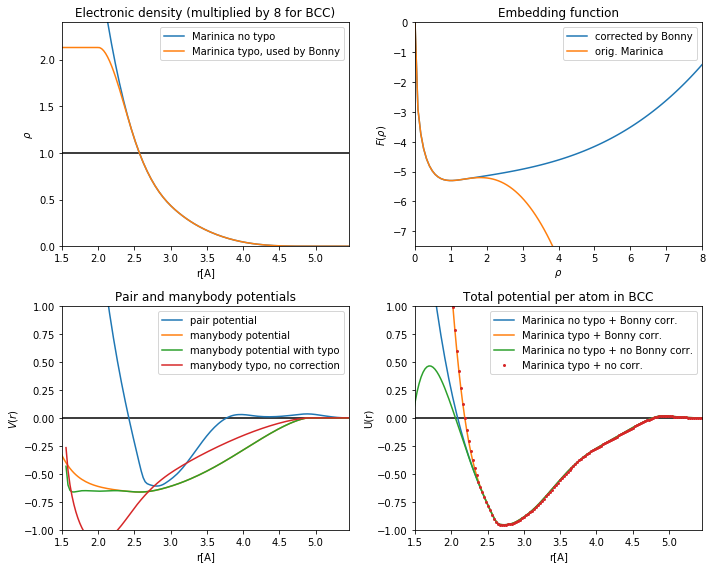

In [74]:
# plot the functions and potentials
rcut = 5.46
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_w_a, rho_w_r)*S*8 for x in r]
dens_old = np.array([rho(x, rho_w_a_old, rho_w_r)*S*8 for x in r])
imax = np.argmax(dens_old)
dens_old[0:imax] = dens_old.max()
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Marinica no typo')
plt.plot(r, dens_old, label='Marinica typo, used by Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [Fa(d, F_w_a, Fc_w_a) for d in dens]
embed_old = [Fe(d, F_w_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='corrected by Bonny')
plt.plot(dens, embed_old, label='orig. Marinica')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_w_a, V_w_r) - 2*C*rho(x, rho_w_a, rho_w_r) for x in r]
#V(x, V_w_a, V_w_r) - 2*C*rho(x, rho_w_a_old, rho_w_r)
pot_manybody = [u_manybody(x) for x in r]
pot_manybody_typo = [u_manybody_typo(x) for x in r]
pot_manybody_marinica = [u_manybody_marinica(x) for x in r]

plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.plot(r, pot_manybody_typo, label='manybody potential with typo')
plt.plot(r, pot_manybody_marinica, label='manybody typo, no correction')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot(x) for x in r]
pot_bonny = [utot_bonny(x) for x in r]
pot_marinica = [utot_marinica(x) for x in r]
pot_marinica_typo = [utot_marinica_typo(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Marinica no typo + Bonny corr.')
plt.plot(r, pot_bonny, label='Marinica typo + Bonny corr.')
plt.plot(r, pot_marinica, label='Marinica no typo + no Bonny corr.')
plt.plot(r, pot_marinica_typo, 'o', ms=2, label='Marinica typo + no corr.')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

### Convert potentials into LAMMPS and Yuri formats

#### Pure elements W

In [160]:
# Ranges of densities and separations
rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

nr = 5000
#rcut = 5.46
rcut = 5.4604375
dr = rcut/nr

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

In [150]:
def u_core(r, za=74, zb=74):
    qe_sq = 14.3992 # squared electron charge  
    rs = 0.4683766/(za**(2/3) + zb**(2/3))**0.5
    x = r/rs
    u  = 0.1818*np.exp(-3.2*x)
    u += 0.5099*np.exp(-0.9423*x)
    u += 0.2802*np.exp(-0.4029*x)
    u += 0.02817*np.exp(-0.2016*x)
    u *= za*zb*qe_sq/r
    return u

def u_combine(r, unucl, ueq, ri=1.0, ro=2.0):
    
    if r < ri:
        u = unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        u = ueq + eta*(unucl - ueq)
    else:
        u = ueq
        
    return u

In [151]:
# Cubic spline function for pair potentials and electronic density
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk])

# Functional form for the embedding potential
f_embed = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)

#fembd = [f_embed(d, F_re_a) for d in dens] # Re
fembd = [Fa(d, F_w_a, Fc_w_a) for d in dens] # W

#edens = [f_spline(x, rho_re_a, rho_re_r) for x in r] # Re
edens = np.array([f_spline(x, rho_w_a_old, rho_w_r)*S for x in r]) # W
imax = np.argmax(edens)
edens[0:imax] = edens.max()

# Pair potential

# 1. Cubic spline for r > r_o
f_outer = [f_spline(x, V_w_a, V_w_r) - 2*C*edens[i]/S for i, x in enumerate(r)]

# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]

# 3. Transition region for r_i < r < r_o
fpair = [x*u_combine(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]

Write LAMMPS format file

In [140]:
with open('W_lv.eam.fs', 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))

## Optimize

Script? Load Module?